In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 5)

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [3]:
import numpy as np
import librosa

from composition.instrument import Score, Part, Phrase, show
import composition.common as k
from utils import QuantileTransformer

* violin: mean: -43.36, std: 5.23
* viola: mean: -42.76, std: 7.77
* cello: mean: -57.26, std: 6.12
* flute: mean: -55.27, std: 8.37
* flute2: mean: -55.27, std: 8.37
- Violin 55-103
- Viola 48-91
- Cello 36-76
- Flute 60-96
- Flute2 55-91

In [4]:
def rescale2(a, mi, ma):
    norm = (a - a[0]) / (a[-1] - a[0])
    return norm * (ma - mi) + mi

In [5]:
def fractal(points, n=3):
    points = np.array(points)
    segments = points.copy()
    for _ in range(n):
        segments = np.concatenate([rescale2(points, f, s)[:-1] for f, s in zip(segments, segments[1:])])
        segments = np.concatenate((segments, points[-1:]))
    return segments

In [6]:
def to_delta(d):
    return d[1:] - d[:-1]

def from_delta(d):
    return np.concatenate([[0], np.cumsum(d)])

In [7]:
def fractal_bpc(values, delta_times, n=0):
    values = fractal(values, n)
    delta_times = to_delta(fractal(from_delta(delta_times), n))
    
    return k.bpc_floor(values, delta_times), delta_times

In [8]:
def fractal_bpc_gliss(values, delta_times, n=0):
    values = fractal(values, n)
    delta_times = to_delta(fractal(from_delta(delta_times), n))
    
    return k.bpc(values, delta_times), delta_times

In [9]:
def rescale(a, mi, ma):
    norm = (a - np.min(a)) / (np.max(a) - np.min(a))
    return norm * (ma - mi) + mi

In [10]:
dur = 16

In [11]:
seed_p = np.array((0, 0.7, 0.3, 1.0))
seed_a = np.array((0, 0.375, 0.625, 1.))

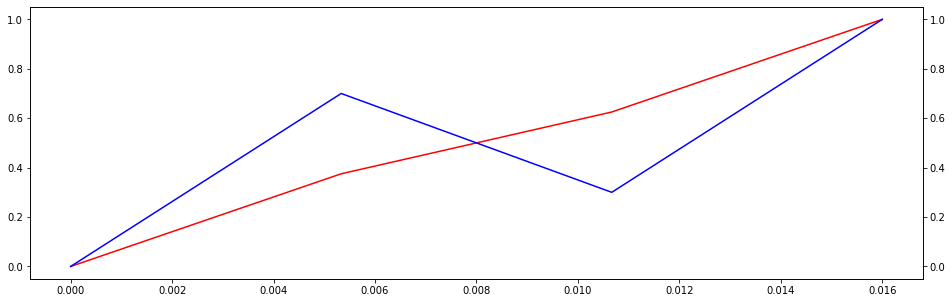

In [12]:
show(seed_p, seed_a)

In [134]:
vln1 = Part('Vln. 1', 'violin')
for i, dr in enumerate([2, 4, 8]):
    seed_d = to_delta(seed_a * dr)
    pitches, durs = fractal_bpc(seed_p, seed_d, i)
    pitches = np.pad(pitches, (0, k.time_to_step(dr) - len(pitches)), constant_values=pitches[-1])
    pitches = (pitches - min(pitches)) / (max(pitches) - min(pitches))
    pitches = k.rescale(pitches, 66, 66+12)
    # pitches = k.autotune(pitches, 0.95, list(np.random.randint(0, 11, 5)))
    pitches = k.autotune(pitches, 0.95)
    pitches += k.sinusoid(dr, 4, 0, 0.125)

    # amps = k.sinusoid(dr, 2/dr, -43.36, 5.23/2)
    amps = np.concatenate([k.triangle(d, 1/d, 0.01) for d in durs])
    # amps += np.random.normal(0, .5, len(amps))
    # amps = k.to_db_loudness(amps, 'violin', min_loudness=-0.1)
    amps = np.pad(amps, (0, k.time_to_step(dr) - len(amps)), constant_values=amps[-1])
    amps = rescale(amps, -55, -44)
    amps += k.line_segment(dr, -12, 4)
    
    vln1.add_phrase(Phrase(pitches, amps))
    
    breathe_p = k.constant(1 + i, pitches[-1])
    vib = k.sinusoid(1+i, 4, 0, 0.125) * (k.phasor(1+i, 1/(1+i)) ** 2)
    breathe_p += vib
    breath_amp = k.phasor(1+i, 1/(1+i)) * 9 - 55
    vln1.add_phrase(Phrase(breathe_p, breath_amp))

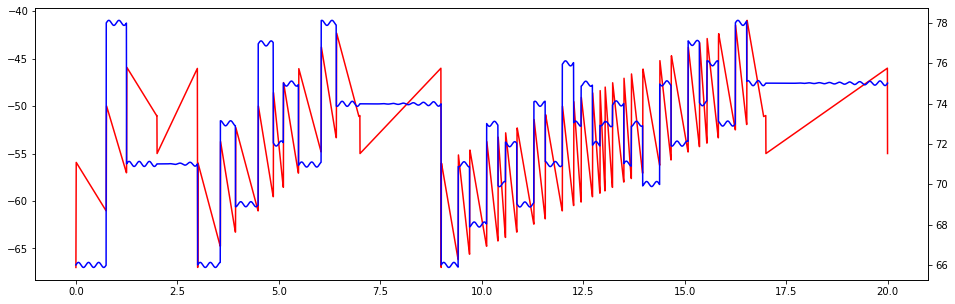

In [14]:
vln1.show()
vln1.play()

In [15]:
vln2 = Part('Vln. 2', 'violin')
for i, dr in enumerate([2, 4, 8]):
    seed_d = to_delta(seed_a * dr)
    pitches, durs = fractal_bpc(seed_p[::-1], np.roll(seed_d, 1), i)
    pitches = np.pad(pitches, (0, k.time_to_step(dr) - len(pitches)), constant_values=pitches[-1])
    pitches = (pitches - min(pitches)) / (max(pitches) - min(pitches))
    pitches = k.rescale(pitches, 61, 61+12)
    # pitches = k.autotune(pitches, 0.95, list(np.random.randint(0, 11, 5)))
    pitches = k.autotune(pitches, 0.95)
    pitches += k.sinusoid(dr, 4, 0, 0.125)

    # amps = k.sinusoid(dr, 2/dr, -43.36, 5.23/2)
    amps = np.concatenate([k.triangle(d, 1/d, 0.01) for d in durs])
    # amps += np.random.normal(0, .5, len(amps))
    # amps = k.to_db_loudness(amps, 'violin', min_loudness=-0.1)
    amps = np.pad(amps, (0, k.time_to_step(dr) - len(amps)), constant_values=amps[-1])
    amps = rescale(amps, -55, -44)
    amps += k.line_segment(dr, -12, 4)
    
    vln2.add_phrase(Phrase(pitches, amps))
    
    breathe_p = k.constant(1 + i, pitches[-1])
    vib = k.sinusoid(1+i, 4, 0, 0.125) * (k.phasor(1+i, 1/(1+i)) ** 2)
    breathe_p += vib
    breath_amp = k.phasor(1+i, 1/(1+i)) * 9 - 55
    vln2.add_phrase(Phrase(breathe_p, breath_amp))

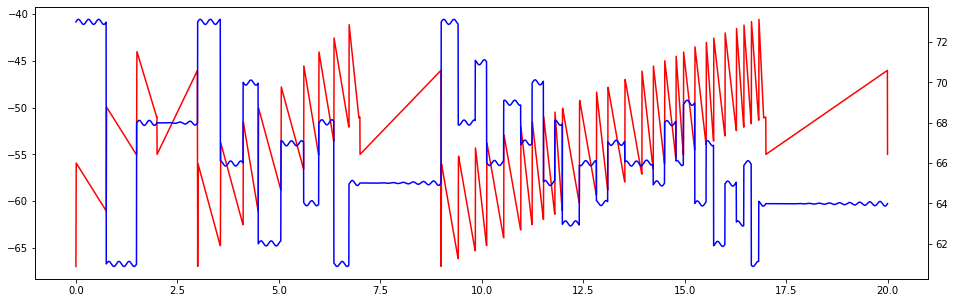

In [16]:
vln2.show()
vln2.play()

In [17]:
flt1 = Part('Flt. 1', 'flute')
silence = Phrase(k.constant(17, 66), k.constant(17, -110))
flt1.add_phrase(silence)
for i, dr in enumerate([1, 2, 4]):
    seed_d = to_delta(seed_a * dr)
    pitches, durs = fractal_bpc(np.roll(seed_p, 1), np.roll(seed_d, 2), i)
    pitches = np.pad(pitches, (0, k.time_to_step(dr) - len(pitches)), constant_values=pitches[-1])
    pitches = (pitches - min(pitches)) / (max(pitches) - min(pitches))
    pitches = k.rescale(pitches, 71, 71+12)
    # pitches = k.autotune(pitches, 0.95, list(np.random.randint(0, 11, 5)))
    pitches = k.autotune(pitches, 0.95)
    pitches += k.sinusoid(dr, 4, 0, 0.125)

    # amps = k.sinusoid(dr, 2/dr, -43.36, 5.23/2)
    amps = np.concatenate([k.triangle(d, 1/d, 0.01) for d in durs])
    # amps += np.random.normal(0, .5, len(amps))
    # amps = k.to_db_loudness(amps, 'violin', min_loudness=-0.1)
    amps = np.pad(amps, (0, k.time_to_step(dr) - len(amps)), constant_values=amps[-1])
    amps = rescale(amps, -55, -54)
    amps += k.line_segment(dr, -8, 0)
    
    flt1.add_phrase(Phrase(pitches, amps))
    flt1.add_phrase(Phrase(pitches[::-1], amps))
    
    breathe_p = k.constant(1 + i, pitches[-1])
    vib = k.sinusoid(1+i, 4, 0, 0.125) * (k.phasor(1+i, 1/(1+i)) ** 2)
    breathe_p += vib
    breath_amp = k.phasor(1+i, 1/(1+i)) * 9 - 55
    flt1.add_phrase(Phrase(breathe_p, breath_amp))

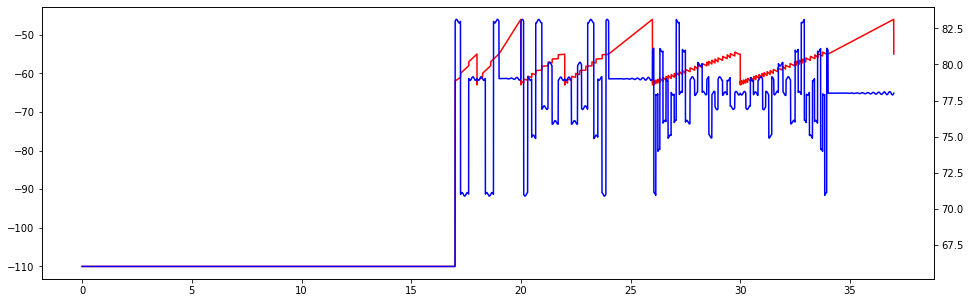

In [18]:
flt1.show()
flt1.play()

In [19]:
flt2 = Part('Flt. 2', 'flute2')
silence = Phrase(k.constant(17, 66), k.constant(17, -110))
flt2.add_phrase(silence)
for i, dr in enumerate([1, 2, 4]):
    seed_d = to_delta(seed_a * dr)
    pitches, durs = fractal_bpc(np.roll(seed_p, 2), np.roll(seed_d, 3), i)
    pitches = np.pad(pitches, (0, k.time_to_step(dr) - len(pitches)), constant_values=pitches[-1])
    pitches = (pitches - min(pitches)) / (max(pitches) - min(pitches))
    pitches = k.rescale(pitches, 66, 66+12)
    # pitches = k.autotune(pitches, 0.95, list(np.random.randint(0, 11, 5)))
    pitches = k.autotune(pitches, 0.95)
    pitches += k.sinusoid(dr, 4, 0, 0.125)

    # amps = k.sinusoid(dr, 2/dr, -43.36, 5.23/2)
    amps = np.concatenate([k.triangle(d, 1/d, 0.01) for d in durs])
    # amps += np.random.normal(0, .5, len(amps))
    # amps = k.to_db_loudness(amps, 'violin', min_loudness=-0.1)
    amps = np.pad(amps, (0, k.time_to_step(dr) - len(amps)), constant_values=amps[-1])
    amps = rescale(amps, -58, -57)
    amps += k.line_segment(dr, -6, 0)
    
    flt2.add_phrase(Phrase(pitches, amps))
    flt2.add_phrase(Phrase(pitches[::-1], amps))
    
    breathe_p = k.constant(1 + i, pitches[-1])
    vib = k.sinusoid(1+i, 4, 0, 0.125) * (k.phasor(1+i, 1/(1+i)) ** 2)
    breathe_p += vib
    breath_amp = k.phasor(1+i, 1/(1+i)) * 9 - 55
    flt2.add_phrase(Phrase(breathe_p, breath_amp))

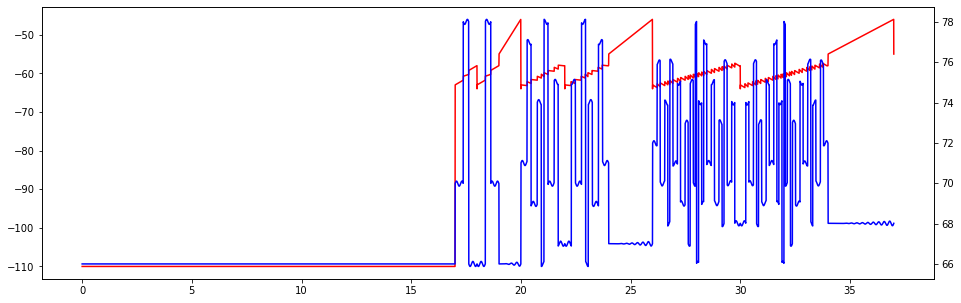

In [20]:
flt2.show()
flt2.play()

In [21]:
# 61 66 68 71

In [116]:
vlc = Part('Vlc', 'cello')
chord = np.array([37, 42])
for i, dr in enumerate([2, 4, 8]):
    seed_d = to_delta(seed_a * dr)
    pitches, durs = fractal_bpc_gliss(np.roll(seed_p, 1), seed_d, i)
    pitches = np.pad(pitches, (0, k.time_to_step(dr) - len(pitches)), constant_values=pitches[-1])
    pitches = (pitches - min(pitches)) / (max(pitches) - min(pitches))
    pitches = k.rescale(pitches, 36, 43)
#     pitches = k.autotune_explicit(pitches, 0.95, chord[i%2:i%2+1])
#     pitches = k.autotune(pitches, 0.95)
    pitches += k.sinusoid(dr, 4, 0, 0.125)

    # amps = k.sinusoid(dr, 2/dr, -43.36, 5.23/2)
    if dr == 8:
        amps = k.line_segment(dr, -63, -57)
    else:
        amps = np.concatenate([k.triangle(d, 1/d, 0.5) for d in durs])
        # amps += np.random.normal(0, .5, len(amps))
        # amps = k.to_db_loudness(amps, 'violin', min_loudness=-0.1)
        amps = np.pad(amps, (0, k.time_to_step(dr) - len(amps)), constant_values=amps[-1])
        # -63 -57 -51
        amps = rescale(amps, -58, -52)
        amps += k.line_segment(dr, -8, 0)
#         amps = k.to_db_loudness(amps, 'cello', min_loudness=-63)
#         amps = np.clip(amps, -np.inf, -40)
    
    vlc.add_phrase(Phrase(pitches, amps))
    
    breathe_p = k.constant(1 + i, pitches[-1])
    vib = k.sinusoid(1+i, 4, 0, 0.125) * (k.phasor(1+i, 1/(1+i)) ** 2)
    breathe_p += vib
    breath_amp = k.phasor(1+i, 1/(1+i)) * 9 - 63
    vlc.add_phrase(Phrase(breathe_p, breath_amp))

In [135]:
from copy import deepcopy

In [152]:
vlc.phrases[:] = deepcopy(vln1.phrases)
for p in vlc.phrases:
    p.pitch -= 24
    p.loudness = rescale(p.loudness, -67, -58)

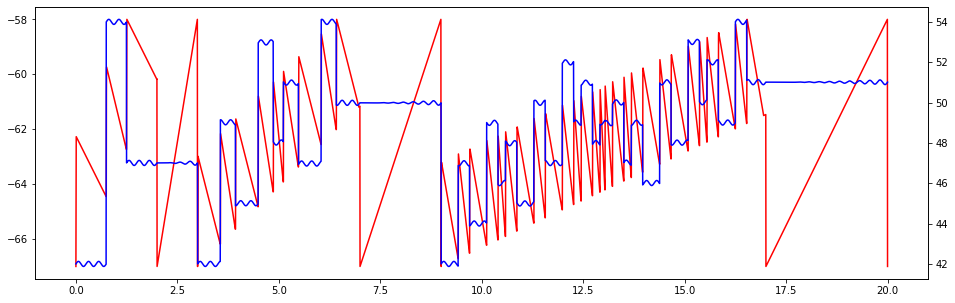

In [153]:
vlc.show()
vlc.play()

In [118]:
vla = Part('Vla', 'viola')
chord = np.array([54, 49])
for i, dr in enumerate([2, 4, 8]):
    seed_d = to_delta(seed_a * dr)
    pitches, durs = fractal_bpc_gliss(np.roll(seed_p, 1), seed_d, i)
    pitches = np.pad(pitches, (0, k.time_to_step(dr) - len(pitches)), constant_values=pitches[-1])
    pitches = (pitches - min(pitches)) / (max(pitches) - min(pitches))
    pitches = k.rescale(pitches, 55, 48)
    pitches = k.autotune_explicit(pitches, 0.95, chord[i%2:i%2+1])
#     pitches = k.autotune(pitches, 0.95)
    pitches += k.sinusoid(dr, 4, 0, 0.125)

    # amps = k.sinusoid(dr, 2/dr, -43.36, 5.23/2)
    if dr == 8:
        amps = k.line_segment(dr, -51, -37)
    else:
        amps = np.concatenate([k.triangle(d, 1/d, 0.01) for d in durs])
        # amps += np.random.normal(0, .5, len(amps))
        # amps = k.to_db_loudness(amps, 'violin', min_loudness=-0.1)
        amps = np.pad(amps, (0, k.time_to_step(dr) - len(amps)), constant_values=amps[-1]) ** 2
        # -51 -43 -35
        amps = rescale(amps, -44, -40)
        amps += k.line_segment(dr, -4, 0)
#         amps = k.to_db_loudness(amps, 'viola', min_loudness=-61)
#         amps = np.clip(amps, -np.inf, -20)
    
    vla.add_phrase(Phrase(pitches, amps))
    
    breathe_p = k.constant(1 + i, pitches[-1])
    vib = k.sinusoid(1+i, 4, 0, 0.125) * (k.phasor(1+i, 1/(1+i)) ** 2)
    breathe_p += vib
    breath_amp = k.phasor(1+i, 1/(1+i)) * 9 - 51
    vla.add_phrase(Phrase(breathe_p, breath_amp))

In [162]:
vla.phrases[:] = deepcopy(vln2.phrases)
for p in vla.phrases:
    p.pitch -= 12
    p.loudness = rescale(p.loudness, -55, -47)

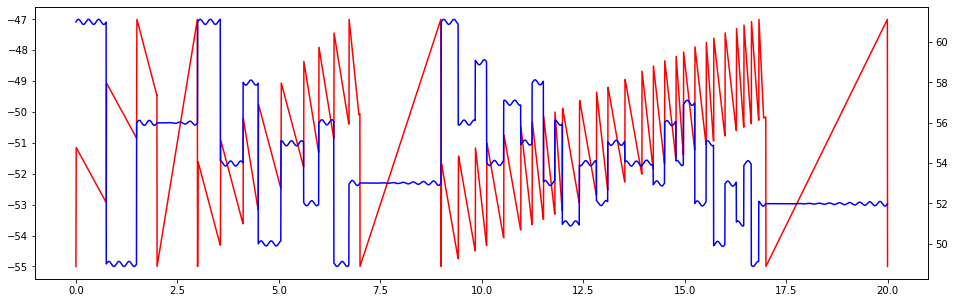

In [163]:
vla.show()
vla.play()

In [164]:
score = Score([vln1, vln2, vla, vlc, flt1, flt2])
# score.show()
# score.play()

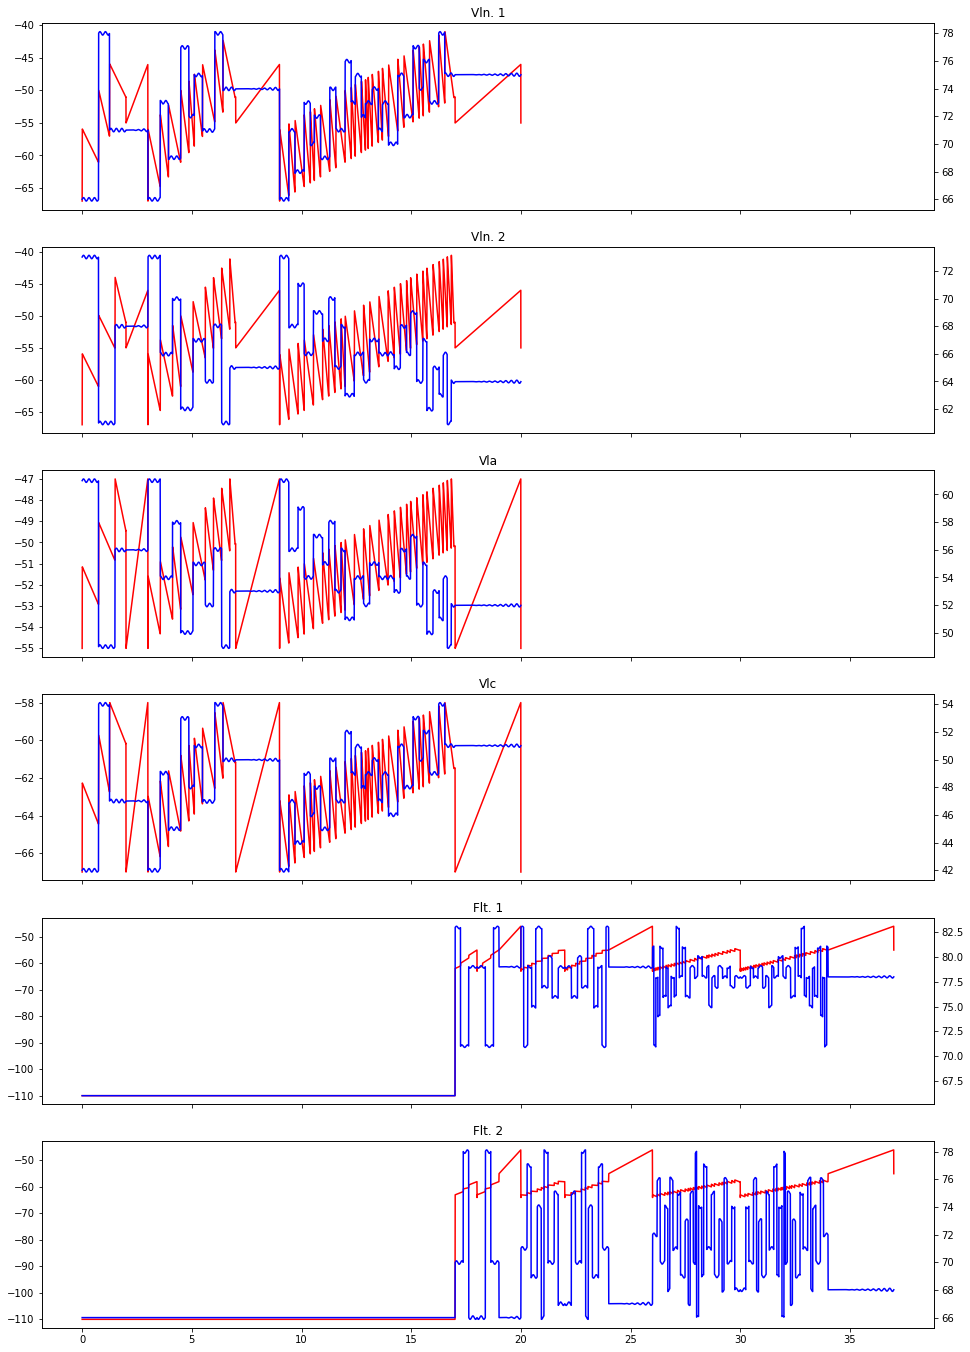

In [165]:
score.save('fractus-duo', './audio-data/december/')